In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from PyEMD import EEMD
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
# Load the data from the file
data = pd.read_csv('PM2.5.csv')

In [3]:
# displaying the DataFrame
display(data)

,Day,PM_Value
0,1/1/2025,278
1,1/2/2025,248
2,1/3/2025,195
3,1/4/2025,239
4,1/5/2025,304
...,...,...
3070,3/27/2016,160
3071,3/28/2016,122
3072,3/29/2016,146
3073,3/30/2016,157


In [4]:
# Convert dates to pandas datetime and sort the data
data['Day'] = pd.to_datetime(data['Day'], format='%m/%d/%Y')
data = data.sort_values('Day')

In [5]:
# Prepare data for decomposition
PM_Value = data['PM_Value'].values

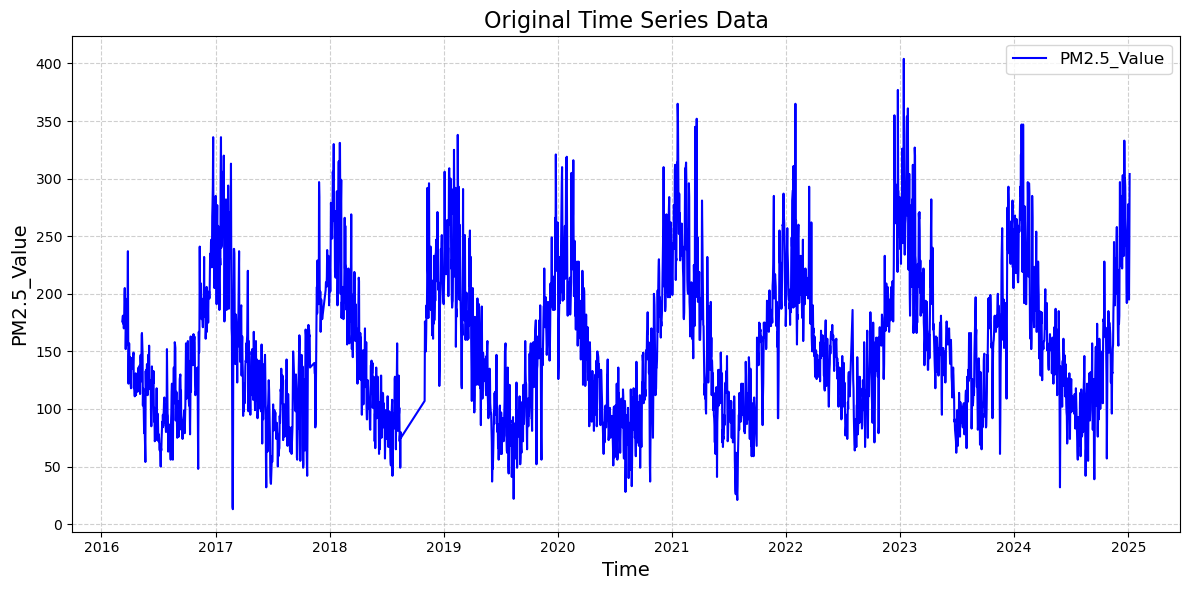

In [8]:
# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(data['Day'], data['PM_Value'], label='PM2.5_Value', color='blue')
plt.title('Original Time Series Data', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('PM2.5_Value', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [9]:
# Decompose using EEMD
eemd = EEMD()
IMFs = eemd.eemd(PM_Value)  # Extract Intrinsic Mode Functions

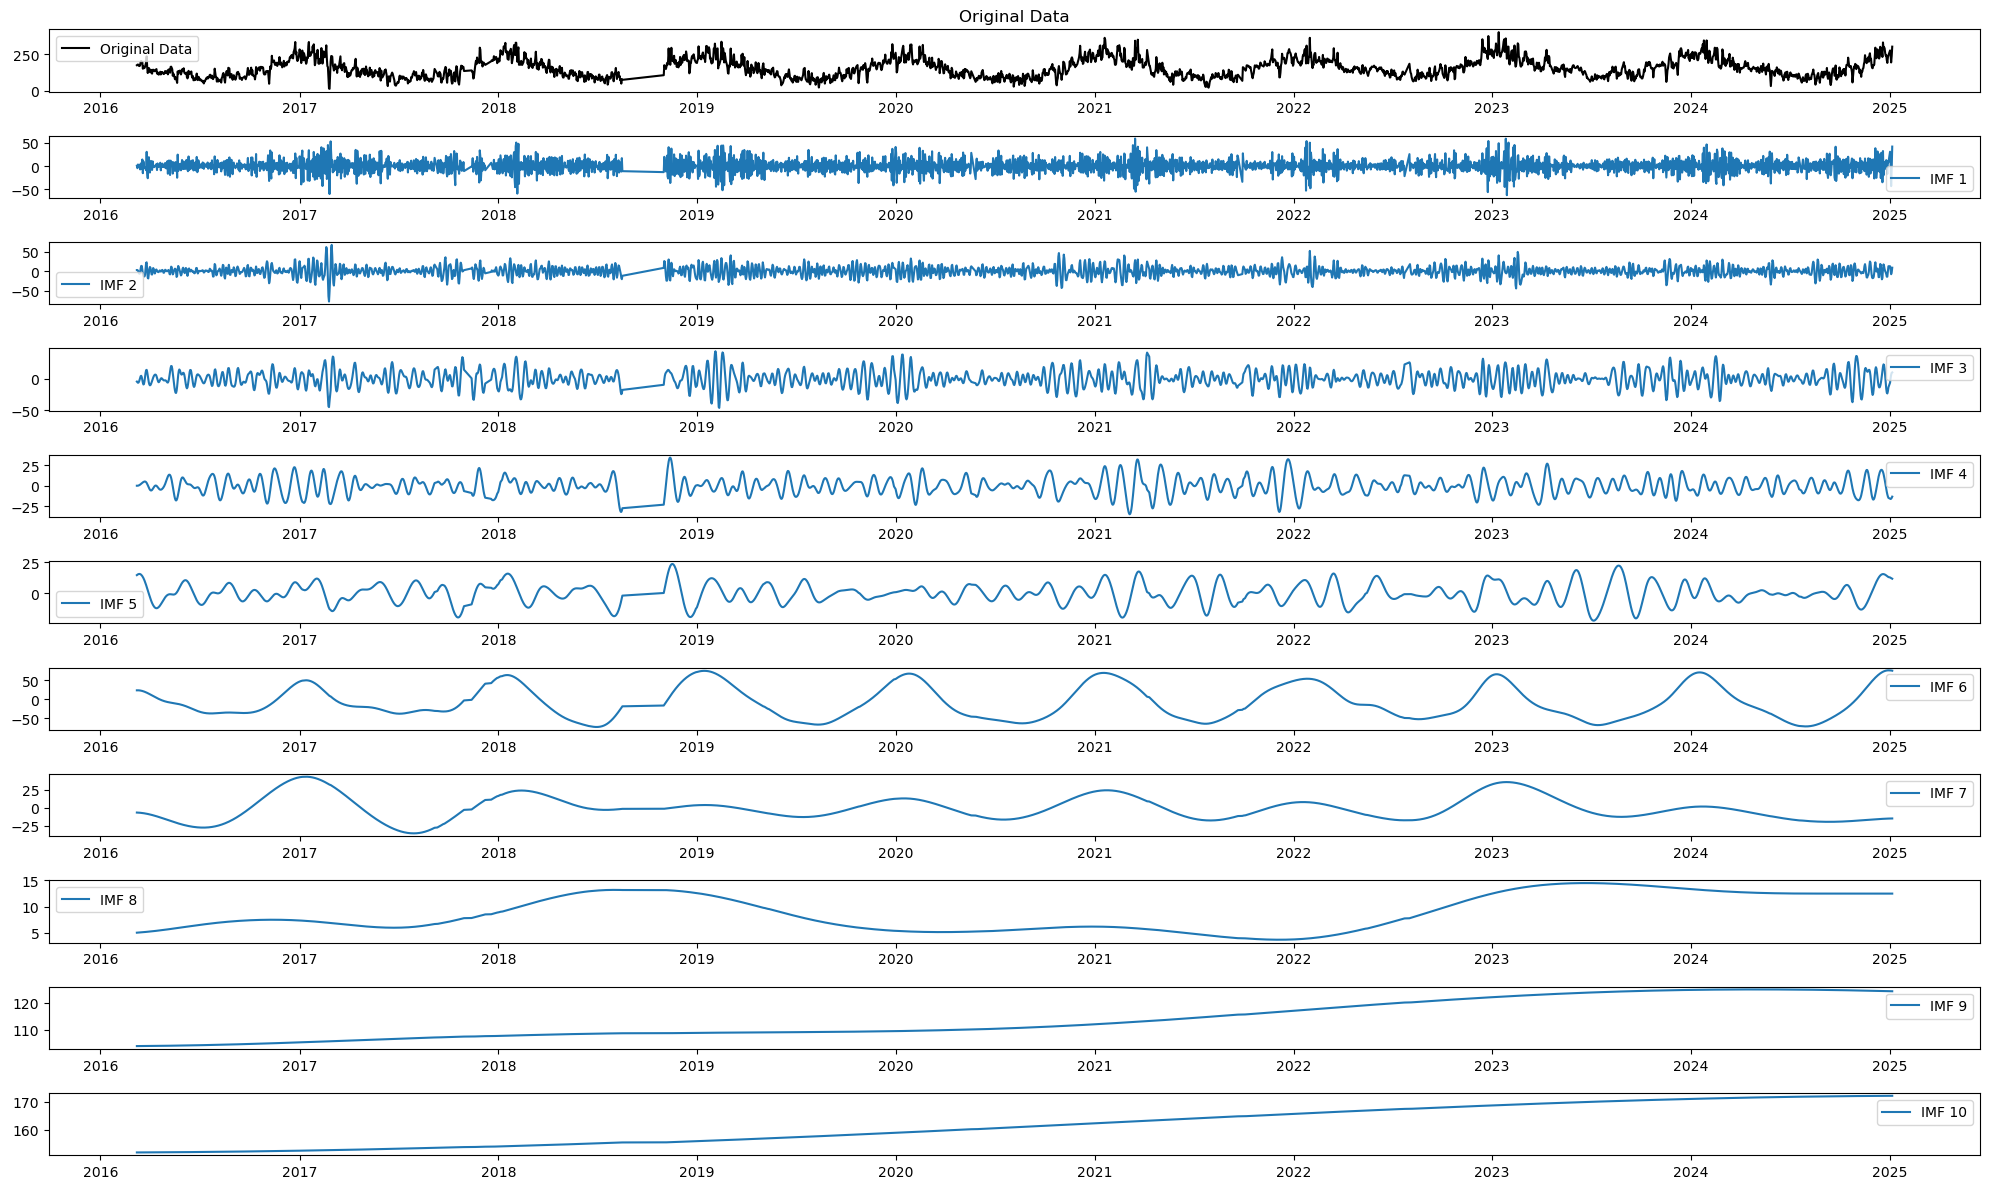

In [10]:
# Plot the original data and IMFs
plt.figure(figsize=(20, 12))
plt.subplot(len(IMFs) + 1, 1, 1)
plt.plot(data['Day'], PM_Value, label='Original Data', color='black')
plt.title('Original Data')
plt.legend()

for i, imf in enumerate(IMFs, start=1):
    plt.subplot(len(IMFs) + 1, 1, i + 1)
    plt.plot(data['Day'], imf, label=f'IMF {i}')
    plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Export IMFs to Excel
imfs_df = pd.DataFrame(IMFs.T, columns=[f'IMF_{i+1}' for i in range(IMFs.shape[0])])
imfs_df.insert(0, 'Date', data['Day'].reset_index(drop=True))
imfs_df.to_excel('IMFsPM.xlsx', index=False)

print("IMFs have been exported to 'IMFsPM.xlsx'.")

IMFs have been exported to 'IMFsPM.xlsx'.


In [12]:
# Step 3: Reconstruct the IMFs without Residual
reconstructed = np.sum(IMFs[:-1], axis=0)  # Exclude the last residual IMF

In [13]:
display(reconstructed)

array([139.17779314, 133.21849337, 139.30392209, ..., 149.1708302 ,
       195.40786441, 256.33682495])

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [15]:
# Load the data from the file
data = pd.read_csv('IMFsPM_NR.csv')

In [16]:
data.head()

,Day,IMF
0,2016-03-08 00:00:00,139.177793
1,2016-03-09 00:00:00,133.218493
2,2016-03-10 00:00:00,139.303922
3,2016-03-11 00:00:00,134.097943
4,2016-03-12 00:00:00,132.952757


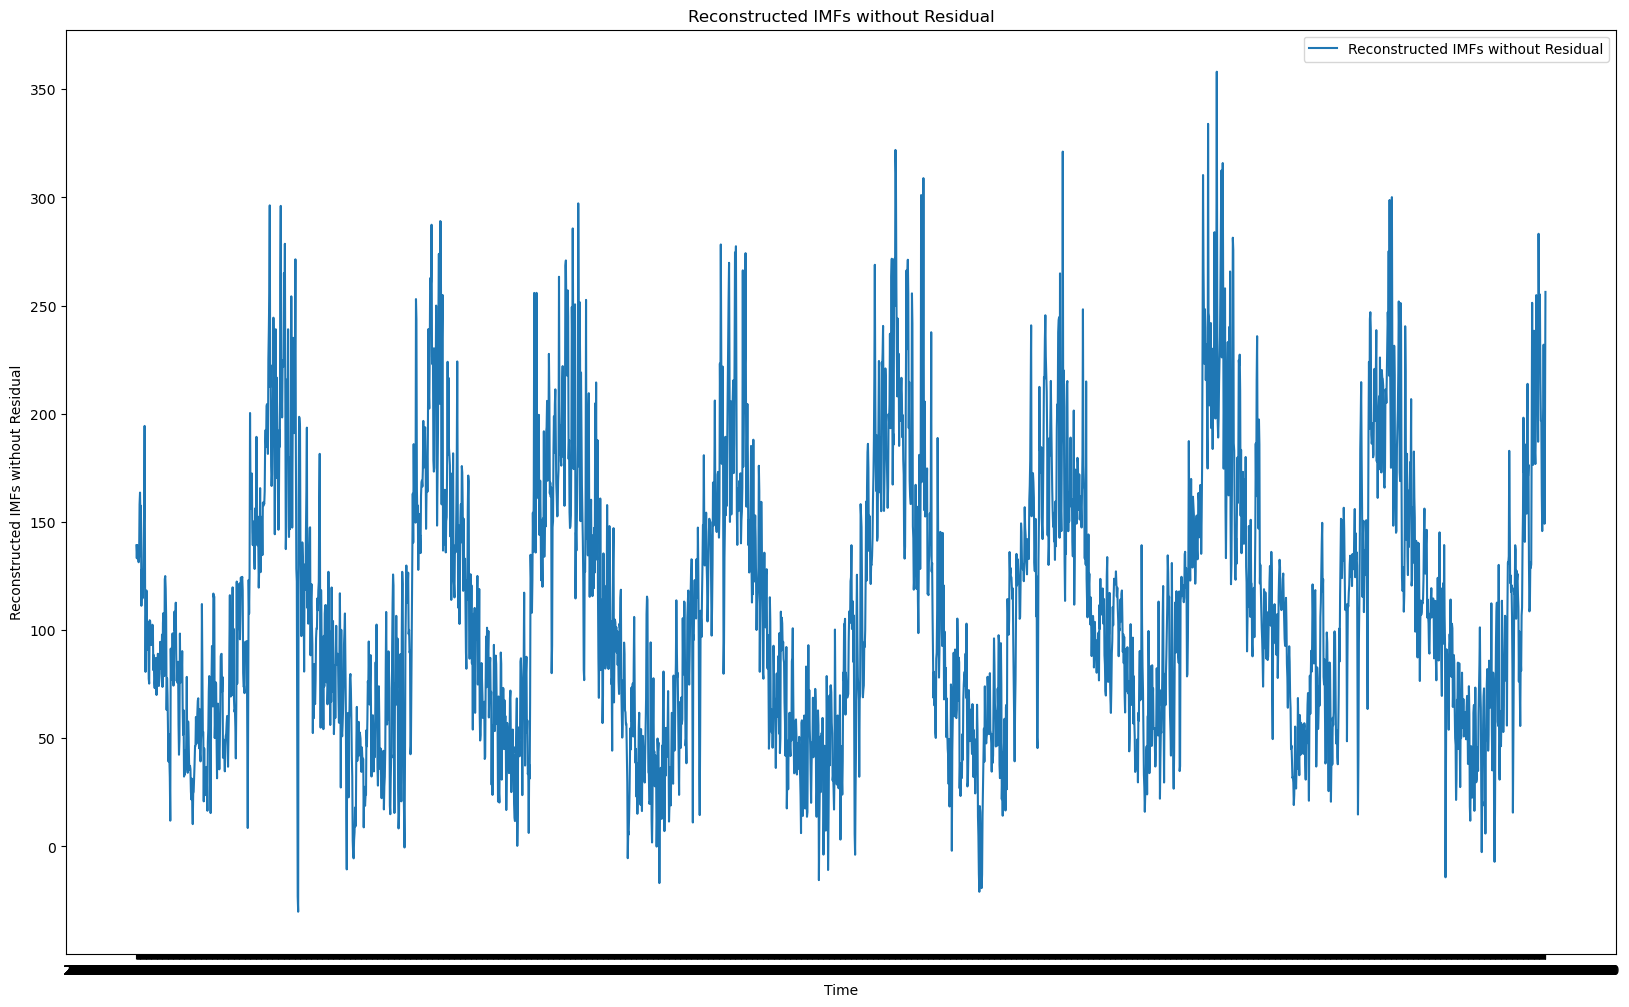

In [17]:
# Data visualization
plt.figure(figsize=(20, 12))
plt.plot(data["Day"], data["IMF"], label="Reconstructed IMFs without Residual")
plt.xlabel("Time")
plt.ylabel("Reconstructed IMFs without Residual")
plt.title('Reconstructed IMFs without Residual')
plt.legend()
plt.show()

In [18]:
# Hyperparameters
lookback = 10
forecast_horizon = 1

In [19]:
# Prepare data for CNN
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data["IMF"].values.reshape(-1, 1)).flatten()
X, y = create_dataset(data_scaled, lookback)

In [20]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Reshape for Conv1D (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [22]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, 1)),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

C:\Users\nhasa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [24]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)

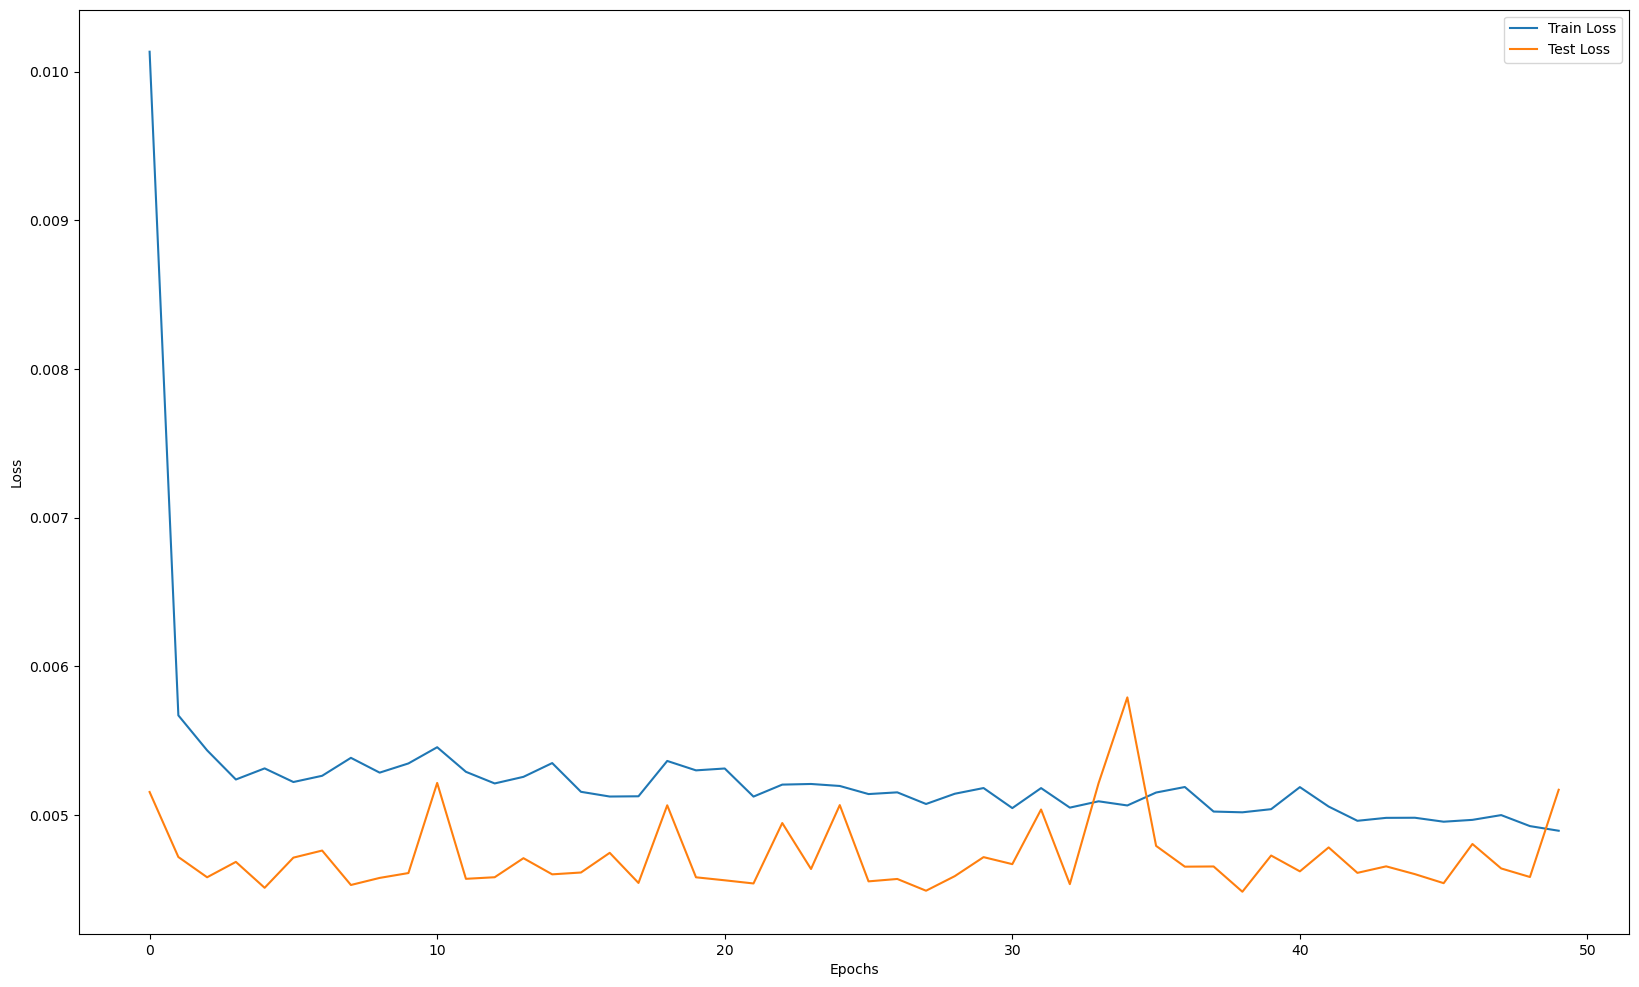

In [25]:
# Plot train-test loss
plt.figure(figsize=(20, 12))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Predictions
y_pred = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [27]:
# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R-Square: {r2:.4f}")

RMSE: 0.0719
MSE: 0.0052
MAPE: 1736298113849.4004
R-Square: 0.8080


In [28]:
# Inverse scale predictions for better interpretation
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_rescaled = scaler.inverse_transform(y_pred).flatten()

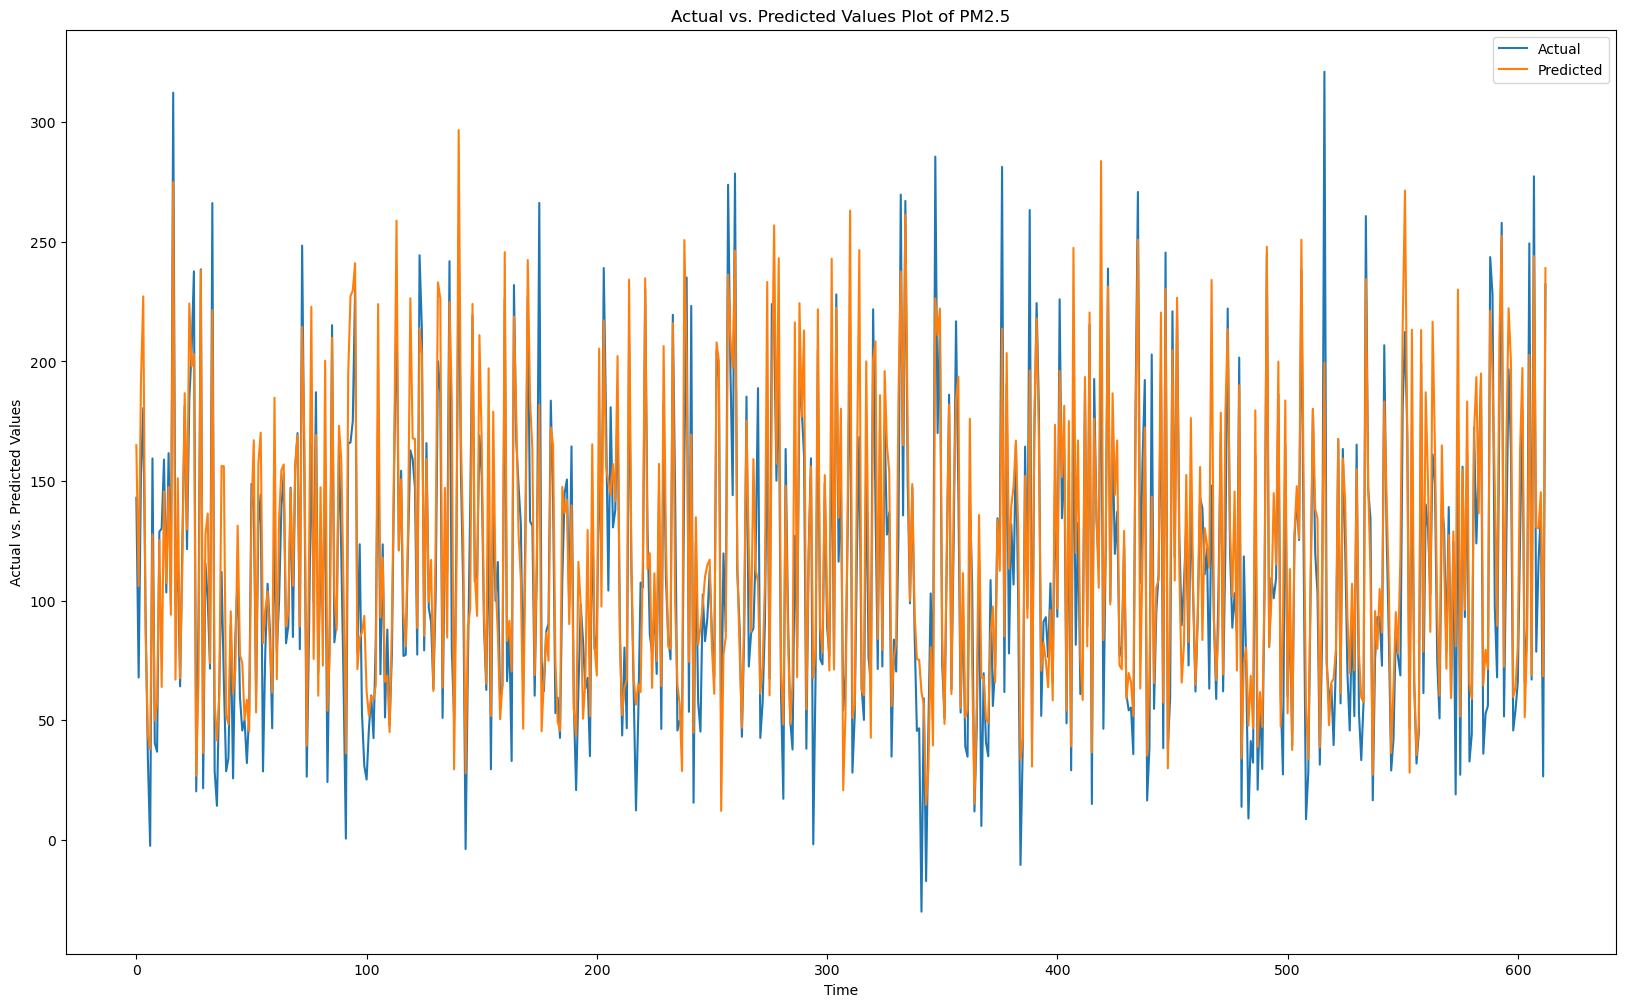

In [29]:
# Plot actual vs predicted
plt.figure(figsize=(20, 12))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Actual vs. Predicted Values')
plt.title('Actual vs. Predicted Values Plot of PM2.5')
plt.legend()
plt.show()


In [30]:
# Forecast next 2 years
future_steps = 730  # Daily, 2 years = 730 days
last_sequence = data_scaled[-lookback:]
forecast = []

for _ in range(future_steps):
    input_seq = last_sequence.reshape(1, lookback, 1)
    next_value = model.predict(input_seq).flatten()[0]
    forecast.append(next_value)
    last_sequence = np.append(last_sequence[1:], next_value)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━

In [31]:
# Inverse scale forecast values
forecast_rescaled = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

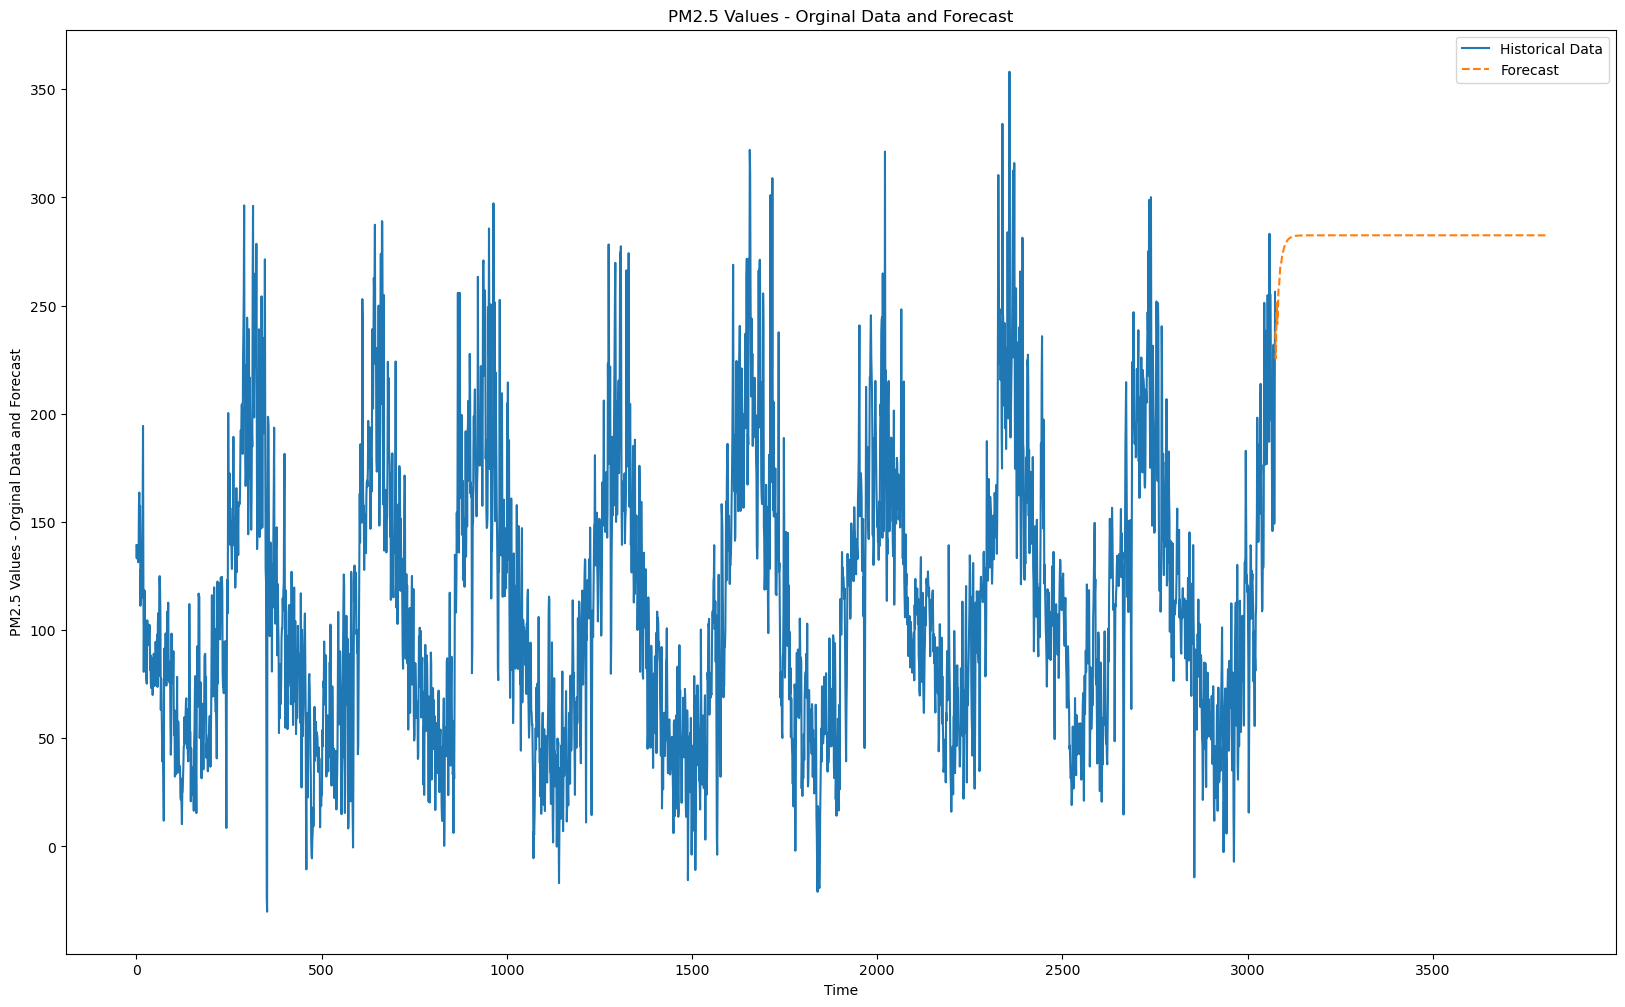

In [33]:
# Plot forecast
plt.figure(figsize=(20, 12))
plt.plot(range(len(data)), data["IMF"], label="Historical Data")
plt.plot(range(len(data), len(data) + future_steps), forecast_rescaled, label="Forecast", linestyle="--")
plt.xlabel("Time")
plt.ylabel("PM2.5 Values - Orginal Data and Forecast")
plt.title('PM2.5 Values - Orginal Data and Forecast')
plt.legend()
plt.show()